In [ ]:
# !pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance

import optuna
from lightgbm import LGBMRegressor, plot_importance

Краткое оглавление разделов:



1.   *Импорт и EDA*
2.   *Создание новых признаков и определение подхода к обучению и выбору моделей*
3.   *Построение моделей и расчет выбраннхы метрик*
    *   Baseline model - **Константа - медиана**
    *   Модели на базе **KNN**
    *   Модели на базе **Gradient Boosting**

4.   *Сравнение полученных моделей и подведение итогов*



# Импорт данных и EDA

Выгрузим данные с предоставленного файла

In [ ]:
# Для удобства вынес путь к файлу в отдельную переменную
path = '/content/data.csv'
data = pd.read_csv(path)

data.head()

,Вектор Мощи,Скорость перехода через портал,Приток Силы Потока,Ритм магического ядра,Поток Энергий,Сила Левого Потока,Сила Правого Потока,Пламя Стихий,Температура вдоха Истока,Температура выдоха Истока,Приток давления Выдоха Истока,Давление вдоха Истока,Давление выдоха Истока,Древний Ветер,Печать Чародея,Эмульсия Истока,Дыхание Истока,Гармония Бессмертия
0,1.138,1.54332,289.964,141.318158,6677.380,7.584,7.584,464.006,736,Исток не вернул выдох,1.096,1.394603,5.947,Древний Ветер развеялся,7.137,0.082,0.95,0.975
1,2.088,3.08664,6960.180,144.111767,6828.469,28.204,28.204,635.401,736,581.658,1.331,1.394603,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,4.62996,8379.229,145.220853,7111.811,60.358,60.358,606.002,736,Исток не вернул выдох,1.389,1.394603,7.574,Древний Ветер развеялся,13.086,0.259,0.95,0.975
3,4.161,6.17328,14724.395,162.050156,7792.630,113.774,113.774,661.471,736,Исток не вернул выдох,1.658,1.394603,9.007,Древний Ветер развеялся,18.109,0.358,0.95,0.975
4,5.140,7.71660,21636.432,201.513586,8494.777,175.306,175.306,731.494,736,645.642,2.078,1.394603,11.197,1.026,26.373,0.522,0.95,0.975


Взглянем на типы данных в таблице

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  11934 non-null  float64
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       11934 non-null  object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           11934 non-null  float64
 12  Давление выдоха Истока          

Видно, что большинство признаков - числовые, однако имеются и два признаки, содержащие строки. Взглянув на эти строки, несложно понять, что они представляют собой заглушки для отсутствующих значений; поэтому, удобно будет заменить их на настоящие пропуски (NaNы)

In [ ]:
@np.vectorize
def transform(x):
    try:
        answ = float(x)
    except:
        answ = np.nan

    return answ

data['Температура выдоха Истока'] = transform(data['Температура выдоха Истока'].values)
data['Древний Ветер'] = transform(data['Древний Ветер'].values)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  11934 non-null  float64
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       2387 non-null   float64
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           11934 non-null  float64
 12  Давление выдоха Истока          

Видно, что пропусков в этих признаках сильно больше половины, что уже ставит под сомнение их значимость. Тем не менее, сперва взглянем на распределение целевой переменной, ибо от него зависит возможность применения тех или иных ML-алгоритмов

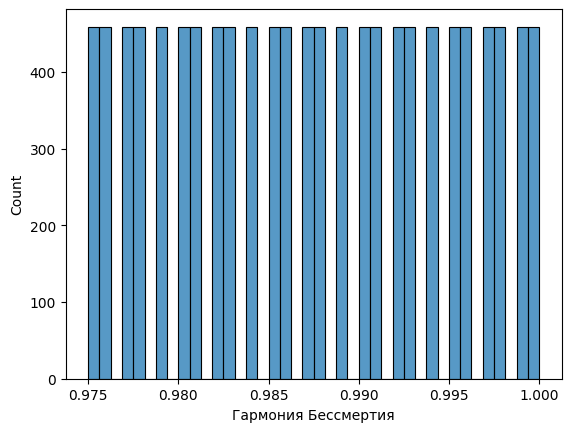

In [ ]:
sns.histplot(data=data, x='Гармония Бессмертия', bins=40)

plt.show()

И тут возникает первая неприятность - хотя и заявлено, что задача регрессионная, вариативность значений целевой переменной **слишком мала**. Решать такую регрессионную задачу стандартными методами (по типу линейной регрессии) будет попросту неэффективно. Тем не менее, в условии были указания по конструированию новых признаков, возможно они смогут выправить ситуацию.

А пока взглянем на вариативность признаков

In [ ]:
data.nunique()

,0
Вектор Мощи,9
Скорость перехода через портал,9
Приток Силы Потока,11430
Ритм магического ядра,3888
Поток Энергий,11834
Сила Левого Потока,4286
Сила Правого Потока,4286
Пламя Стихий,11772
Температура вдоха Истока,1
Температура выдоха Истока,2368


И снова возникает неприятность - имеются признаки с ну очень уж малым числом уникальных значений (например, *Вектор Мощи*); имеются и "мусорные" признаки, принимающие одно значение на всех данных (*Температура вдоха* и *Давление вдоха*). Это сигнализирует о необходимости перевода таких признаков в разряд **качественных** или об их **удалении**.

Напоследок взглянем на корреляцию признаков между собой, так как мощная интеркорреляция может сильно занизить качество линейных моделей

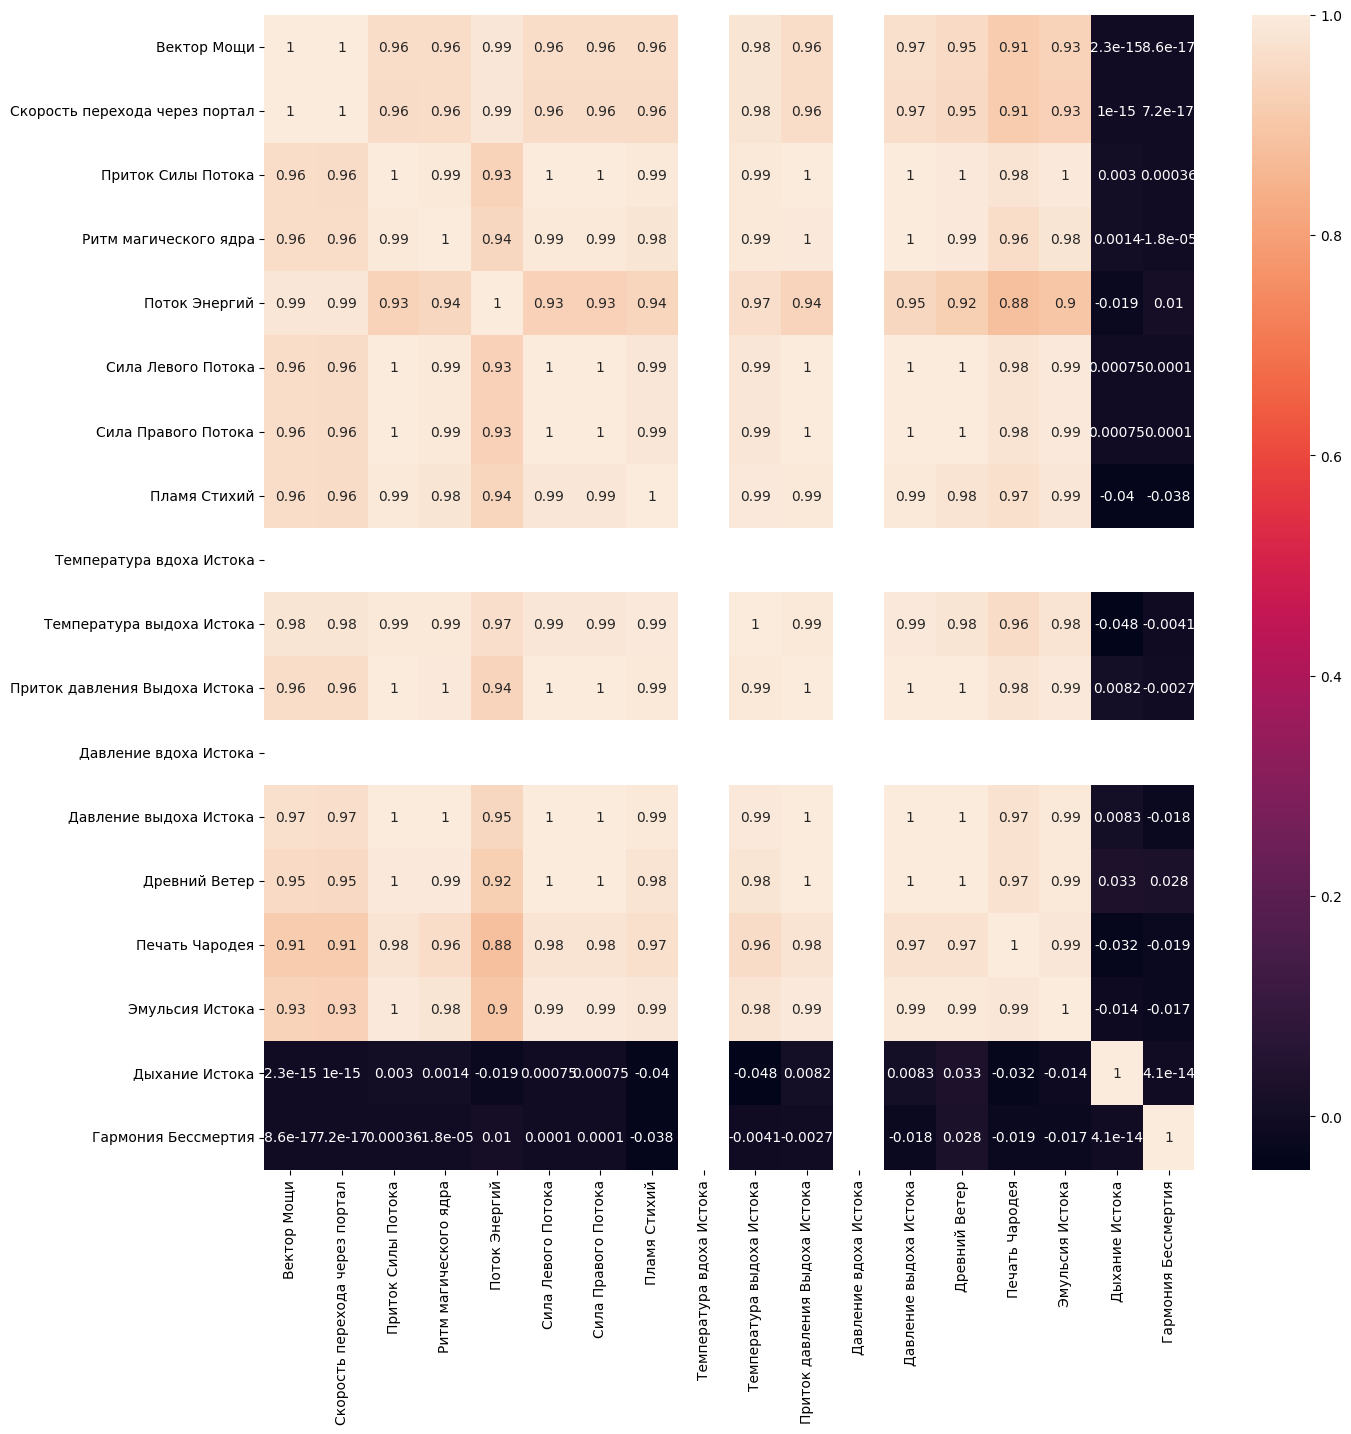

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(numeric_only=True), annot=True)

plt.show()

И третья неприятность - повальная **интеркорреляция признаков**; как уже было отмечено, это негативно влияет на класс простых линейных моделей. Кроме того, корреляция признаков с целевой переменной **практически отсутствует**, что в целом ставит под сомнение возможность применения данного признакового пространства в предсказании

Напоследок, зафиксируем выделенные проблемные места:


*   *Малая, для задач регрессии, вариативность целевой переменной*
*   *Наличие признаков с большим количеством пропусков/малой вариативностью значений*
*   *Серьезная мультиколлинеарность признаков*
*   *Слабая корреляционная связь признаков с целевой переменной*



# Конструирование новых признаков и их обзор

Прежде чем приступать к обучению моделей, применим советы по созданию новых показателей

In [ ]:
base_columns = set(data.columns)

In [ ]:
# На всякой случай запомним старые признаки
data_old = data.copy(deep=True)

# Новые признаки
data['Общая мощность потоков'] = data['Сила Левого Потока'] + data['Сила Правого Потока']
data['Суммарная сила потоков'] = data['Общая мощность потоков'] + data['Приток Силы Потока']
data['Общая сила ядра'] = data['Ритм магического ядра'] * data['Приток Силы Потока']
data['Общее давление на выходе'] = data['Приток давления Выдоха Истока'] + data['Давление выдоха Истока']
data['Магическая производительность'] = data['Скорость перехода через портал'] / data['Эмульсия Истока']
data['Эффективность ядра'] = data['Общая сила ядра'] / data['Эмульсия Истока']
data['Магическая мощность'] = data['Эмульсия Истока'] * data['Общее давление на выходе'] / (data['Пламя Стихий'] - data['Температура вдоха Истока'])

# Новые целевые переменные
data['Степень износа источников'] = data['Дыхание Истока'] / data['Гармония Бессмертия']
data['Расхождение в стабильности'] = abs(data['Дыхание Истока'] - data['Гармония Бессмертия'])
data['Баланс угасания'] = (data['Дыхание Истока'] - data['Гармония Бессмертия']) / data['Скорость перехода через портал']

used_cols = {'Сила Левого Потока', 'Сила Правого Потока', 'Приток Силы Потока', 'Ритм магического ядра', 'Приток давления Выдоха Истока', 'Скорость перехода через портал',
             'Эмульсия Истока', 'Пламя Стихий', 'Температура вдоха Истока'}
recovery_cols = {'Дыхание Истока', 'Скорость перехода через портал'}

# Очистим новый набор от всех старых признаков, кроме тех, что нужны для восстановления старой целевой переменной
data.drop(columns=list(base_columns - recovery_cols), inplace=True)

Сперва взглянем на распределение новых целевых показателей

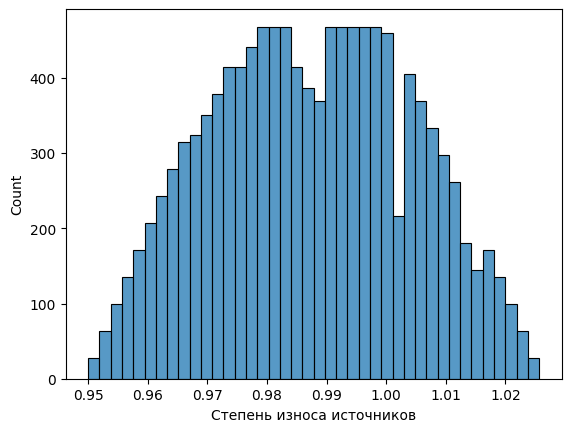

In [ ]:
sns.histplot(data=data, x='Степень износа источников', bins=40)

plt.show()

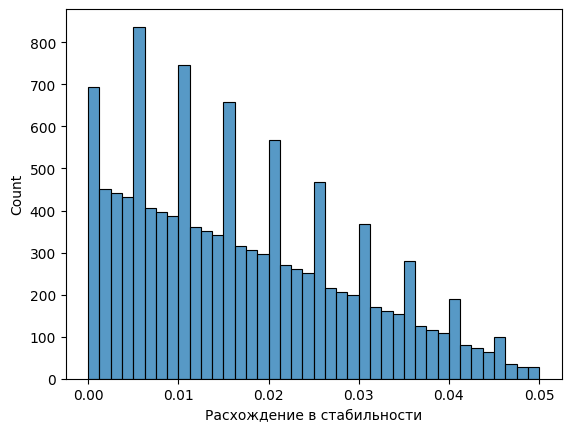

In [ ]:
sns.histplot(data=data, x='Расхождение в стабильности', bins=40)

plt.show()

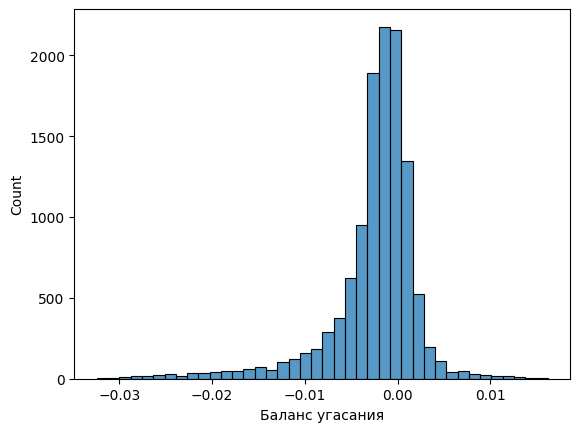

In [ ]:
sns.histplot(data=data, x='Баланс угасания', bins=40)

plt.show()

С точки зрения распределений полученные целевые переменные значительно лучше предыдущих (что хорошо). Посмотрим на вариативность признаков

In [ ]:
data.nunique()

,0
Скорость перехода через портал,9
Дыхание Истока,51
Общая мощность потоков,4286
Суммарная сила потоков,11567
Общая сила ядра,11859
Общее давление на выходе,5678
Магическая производительность,770
Эффективность ядра,11933
Магическая мощность,11934
Степень износа источников,1301


Все новые признаки достаточно вариативны, что так же хорошо для задач регрессии и позволяет обойтись без качественных переменных. Теперь оценим интеркорреляцию

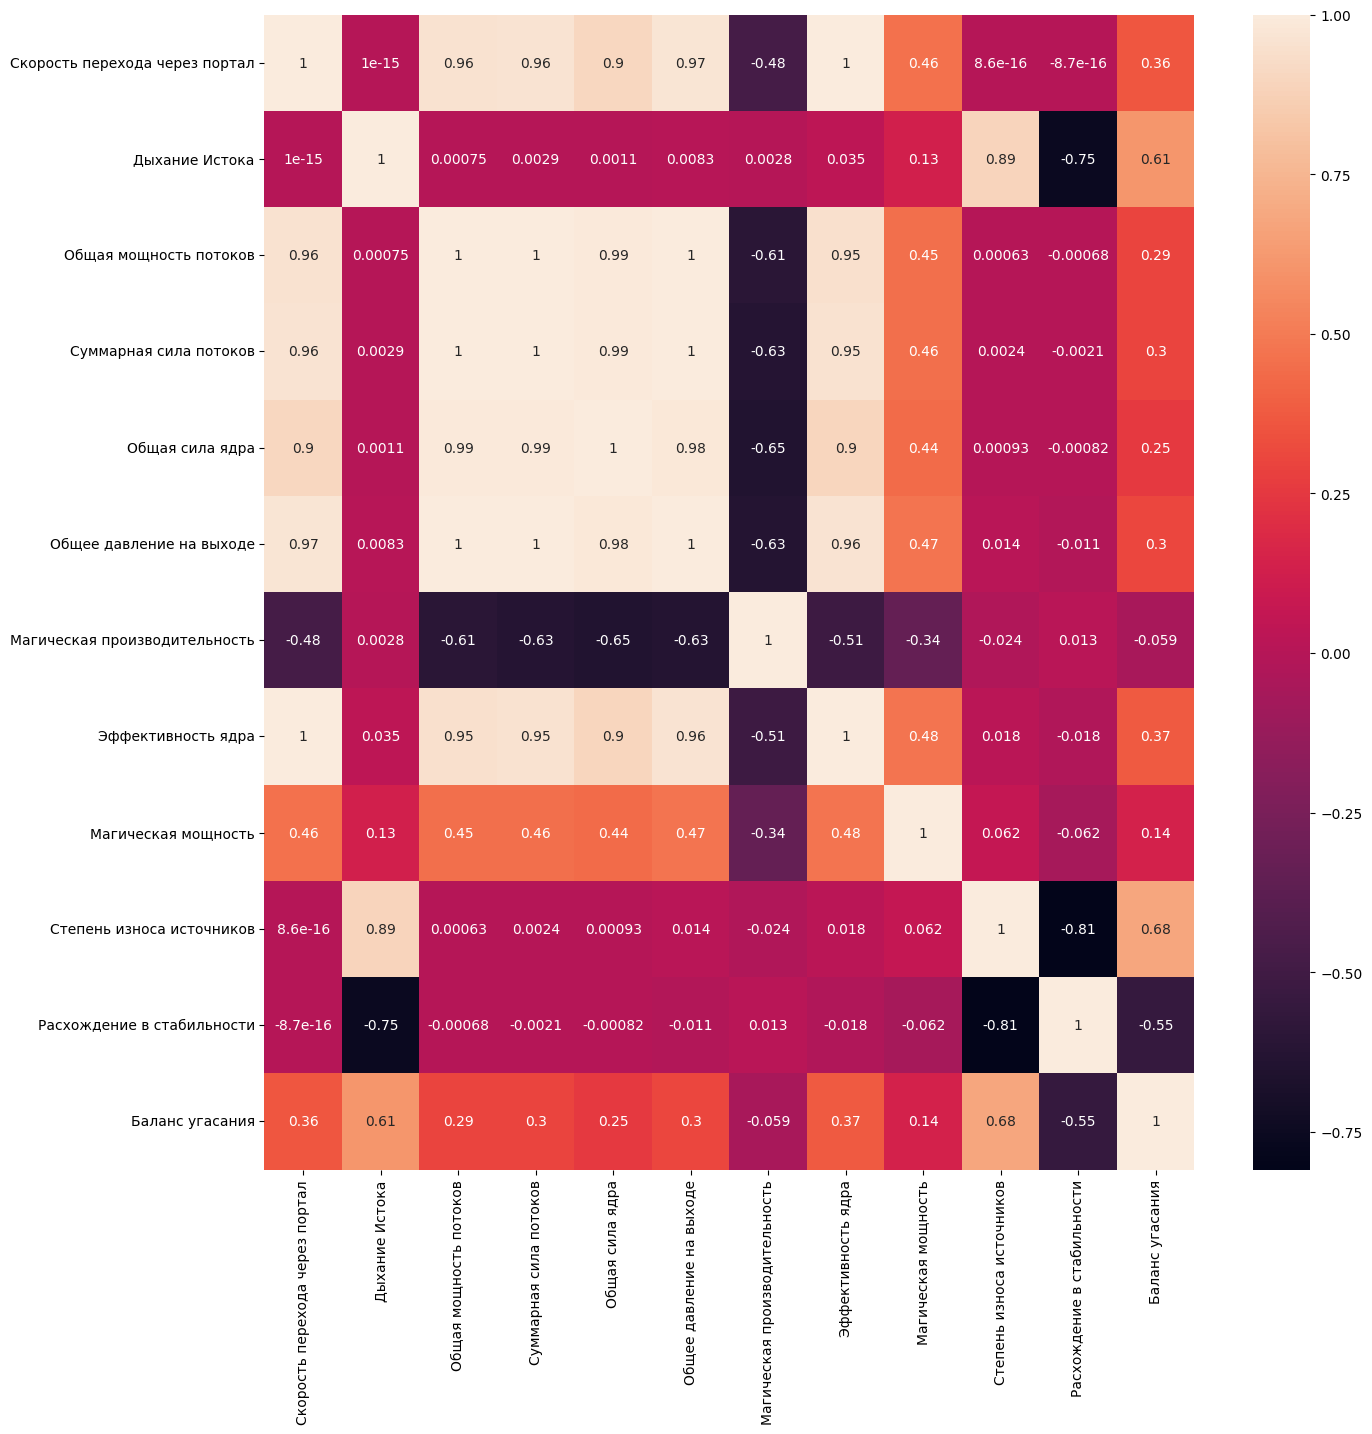

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(numeric_only=True), annot=True)

plt.show()

Здесь все еще осталась мультколлинеарность, однако выделились и достаточно независимые показатели. Кроме того, существенно улучшилась корреляция с новыми целевыми переменными (особенно с *Балансом угасания*); значит, применение такого признакового пространства лучше для выявления искомой зависимости

Ну и напоследок, небольшой технический аспект, свзанный с потребностью в масштабировании новых признаков (что зачастую важно в регрессионных моделях); для понимания необходимости этого действия, выведем основные статистики по признакам

In [ ]:
data.describe()

,Скорость перехода через портал,Дыхание Истока,Общая мощность потоков,Суммарная сила потоков,Общая сила ядра,Общее давление на выходе,Магическая производительность,Эффективность ядра,Магическая мощность,Степень износа источников,Расхождение в стабильности,Баланс угасания
count,11934.000000,11934.00000,11934.000000,11934.000000,1.193400e+04,11934.000000,11934.000000,1.193400e+04,11934.000000,11934.000000,11934.000000,11934.000000
mean,7.716600,0.97500,454.671536,27702.170222,7.872392e+06,14.650086,13.824310,8.777894e+06,0.049550,0.987399,0.016912,-0.002546
std,3.985002,0.01472,400.991779,22549.280662,8.488915e+06,6.421678,4.261145,4.404463e+06,0.169548,0.016688,0.011965,0.004934
min,1.543320,0.95000,10.608000,267.547000,3.556916e+04,6.924000,4.566036,4.373923e+05,-1.537850,0.950000,0.000000,-0.032398
25%,4.629960,0.96200,120.634000,8496.517500,1.216337e+06,8.837000,10.410253,4.924213e+06,-0.017300,0.974516,0.007000,-0.003645
50%,7.716600,0.97500,350.536000,21981.202000,4.358900e+06,13.175000,13.637585,8.785057e+06,-0.004554,0.987346,0.015000,-0.001620
75%,10.803240,0.98800,664.729500,39666.143750,1.093774e+07,18.635000,17.893565,1.272738e+07,0.149047,1.000000,0.025000,0.000000
max,13.889880,1.00000,1290.498000,74075.284000,2.714001e+07,27.700000,25.094634,1.592358e+07,0.886172,1.025641,0.050000,0.016199


Видно, что показатели различаются по масштабу, поэтому необходимо будет провести их масштабирование, прежде чем переходить к обучению

Как итог, следует отметить, что предложенные признаки позволяют решить ряд существенных проблем с исходными данными; следовательно, **представляется целесообразным использовать именно новые показатели** для построения
регрессионных моделей (тем более, даже по своему чисто логическому содержанию, они *лучше характеризуют непосредственно работу портала*)

Теперь сформулируем общий подход для оценки эффективности моделей:



1.   Как уже было сказано выше, пытаться предсказывать мы будем не исходную целевуо переменную, а преобразованные показатели (*Стпень износа/Расхождение в стабильности/Баланс угасания*). Это вызвано **малой вариативностью исходной целевой переменной**, что плохо отражается на качестве регрессионных моделей.
2.   Не смотря на то, что предсказываться будут измененные таргеты, **метрики качества считаются на обратном преобразовании**; в конце концов, мы хотим как можно лучше предсказывать именно исходный показатель, а не производные от него.
3.   Касательно метрик качества. В силу того, что исходная целевая переменная достаточно мала (в абсолютном значении), станадартная метрика MSE может занижать величину ошибки (будут возводиться в квадарат числа < 1); поэтому, в качестве метрики качества используется мера MAE (лучше оценивает ошибку отклонения на малых участках). Кроме того, хотелось бы считать и некоторую относительную величину, которая позволила бы оценить относительную эффективность применения алгоритмов. Для этого используется метрика relative MAE:

$$
relMAE = \frac{MAE}{MAE_{baseline}}
$$

Другими словами, данная метрика - показатель относительного отклонения метрики качества модели от бейзлайна: если показатель < 1, то модель лучше по данной метрике качества, а если > 1 - хуже. В качестве бейзлайна используются константные предсказания. Кроме того relative MAE считается как относительного **бейзлана конкретного таргета**, так и **лучшего бейзлайна среди всех таргетов**

4.   Подход к оценке качества моделей следующий:
    *   Берется пара тип модели-целевой признак
    *   Через функционал библиотеки ```optuna``` подбираются оптимальные значения гиперпараметров (критерий отбора - оценка MAE на кросс-валидации по обучающей выборке)
    *   Далее модель с оптимальными гиперпараметрами обучается, для признаков строится график их значимости для модели
    *   Делаются предсказания на отложенной выборке, рассчитываются метрики качества

5.  Предварительно разделим исходную выборку на обучение и контроль (30% под контроль) и отмасштабируемые значения признаков на отрезок [0;1] (для этого воспользуемся ```MinMaxScaler```)


# Обучение моделей

In [ ]:
# Чтобы избежать ликов исключим признаки для восстановления исходной целевой переменной
X_train, X_test, y_train1, y_test1 = train_test_split(data.drop(columns=['Степень износа источников', 'Расхождение в стабильности', 'Баланс угасания',
                                                                         'Дыхание Истока', 'Скорость перехода через портал']), data['Баланс угасания'], test_size=0.3, random_state=42)
columns_taken = X_train.columns

In [ ]:
y_train2 = data.loc[y_train1.index, 'Степень износа источников']
y_test2 = data.loc[y_test1.index, 'Степень износа источников']
y_train3 = data.loc[y_train1.index, 'Расхождение в стабильности']
y_test3 = data.loc[y_test1.index, 'Расхождение в стабильности']

In [ ]:
# Масштабирование признаков
scaler = MinMaxScaler()
scaler.set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_train.columns = columns_taken
X_test = scaler.transform(X_test)
X_test.columns = columns_taken

In [ ]:
# Будем сохранять все результаты, чтобы потом свести воедино
model_maes = []
model_relmaes = []
model_relmaes_best = []

## Baseline - Константные прогнозы на MAE

Так как основной метрикой является MAE, то наилучшим константным прогнозом будет **медиана по обучающей выборке**

### Target - Баланс угасания

In [ ]:
const_model1 = np.median(y_train1)
baseline_mae1 = mean_absolute_error(data_old.loc[y_test1.index, 'Гармония Бессмертия'], data.loc[y_test1.index, 'Дыхание Истока'] -
                               data.loc[y_test1.index, 'Скорость перехода через портал'] * (np.ones(y_test2.shape) * const_model1))

baseline_mae1

0.014745462161407435

### Target - Степень износа источников

In [ ]:
const_model2 = np.median(y_train2)
baseline_mae2 = mean_absolute_error(data_old.loc[y_test2.index, 'Гармония Бессмертия'], data.loc[y_test2.index, 'Дыхание Истока'] / (np.ones(y_test2.shape) * const_model2))

baseline_mae2

0.013902874377664754

### Target - Расхождение в стабильности

In [ ]:
const_model3 = np.median(y_train3)
baseline_mae3 = mean_absolute_error(data_old.loc[y_test3.index, 'Гармония Бессмертия'],  data.loc[y_test3.index, 'Дыхание Истока'] + np.ones(y_test3.shape) * const_model3)

baseline_mae3

0.013865679977659886

### Усреднение прогнозов по трем таргетам

In [ ]:
pred1 = data.loc[y_test1.index, 'Дыхание Истока'] - data.loc[y_test1.index, 'Скорость перехода через портал'] * (np.ones(y_test2.shape) * const_model1)
pred2 = data.loc[y_test2.index, 'Дыхание Истока'] / (np.ones(y_test2.shape) * const_model2)
pred3 = data.loc[y_test3.index, 'Дыхание Истока'] + np.ones(y_test3.shape) * const_model3

mean_predict = (pred1 + pred2 + pred3) / 3

const_mean_mae = mean_absolute_error(data_old.loc[y_test1.index, 'Гармония Бессмертия'], mean_predict)
const_mean_mae

0.0139741318189371

### Лучшее константное предсказание

Наименьшее MAE обеспечивает восстановленние по медиане третьего таргета, поэтому для второй relative MAE (смотри выше) будем использовать его метрику

In [ ]:
best_baseline_mae = baseline_mae3

## KNeighbors

Одним из потенциальных вариантов улучшения прогнозной модели может быть применения метода ближайших соседей, ибо логично предполагать схожесть показателей у порталов с близким значением Гармонии Бессмертия (и, как следствие, производных от него целевых показателей) + данная модель не особо чувствительна к оставшейся мультиколлинеарности признаков. На кросс-валидации в моделях подбираются наиболее значимые гиперепараметры метода - *кол-во ближайших соседей* и *степень в используемой метрике расстояния*. Важность признаков счиатеся через метод ```permutation importance``` (встроенных методов оценки важности здесь нет)

### Target - Баланс угасания

In [ ]:
def objective_knn1(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 200, log=False),
        'weights': 'distance',
        'p': trial.suggest_float('p', 1, 5, log=False)
    }

    regr = KNeighborsRegressor(**params)

    return cross_val_score(regr, X_train, y_train1, scoring='neg_mean_absolute_error').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn1, n_trials=100)

[I 2024-11-13 12:31:50,658] A new study created in memory with name: no-name-17c48056-3554-438f-9a13-63d190575cde
[I 2024-11-13 12:31:51,968] Trial 0 finished with value: -0.0017777976244769014 and parameters: {'n_neighbors': 200, 'p': 2.385119628146707}. Best is trial 0 with value: -0.0017777976244769014.
[I 2024-11-13 12:31:52,986] Trial 1 finished with value: -0.0016756806105880724 and parameters: {'n_neighbors': 149, 'p': 3.4644397147253705}. Best is trial 1 with value: -0.0016756806105880724.
[I 2024-11-13 12:31:53,491] Trial 2 finished with value: -0.0012468839175515812 and parameters: {'n_neighbors': 45, 'p': 3.2284984461029014}. Best is trial 2 with value: -0.0012468839175515812.
[I 2024-11-13 12:31:54,389] Trial 3 finished with value: -0.0015515656560446463 and parameters: {'n_neighbors': 115, 'p': 1.2948752482629695}. Best is trial 2 with value: -0.0012468839175515812.
[I 2024-11-13 12:31:54,744] Trial 4 finished with value: -0.0010636986312425266 and parameters: {'n_neighbor

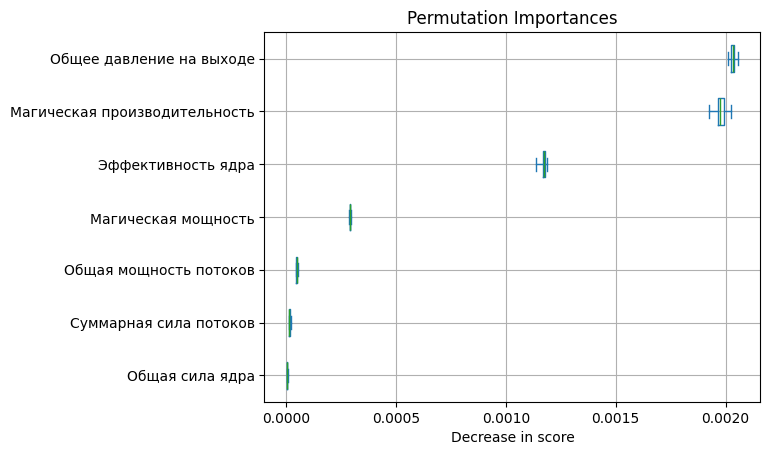

In [ ]:
best_knn1 = KNeighborsRegressor(**study.best_params).fit(X_train, y_train1)

result = permutation_importance(best_knn1, X_train, y_train1, n_repeats=10, random_state=0, n_jobs=-1, scoring='neg_mean_absolute_error')
sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

importances.plot.box(vert=False, whis=10)
plt.title("Permutation Importances")
plt.grid()
plt.xlabel("Decrease in score")
plt.show()

По построенному графику видно малую важность признаков *Общая сила ядра* и *Суммарная сила потоков*. В теории, можно их исключить из рассмотрения без серьезной потери качества (конкретно для данной целевой переменной)

Рассчитаем метрики качества

In [ ]:
knn1_mae = mean_absolute_error(data_old.loc[y_test1.index, 'Гармония Бессмертия'], data.loc[y_test1.index, 'Дыхание Истока'] -
                               data.loc[y_test1.index, 'Скорость перехода через портал'] * best_knn1.predict(X_test))
model_maes.append(knn1_mae)
knn1_mae

0.0023659126873312878

In [ ]:
knn1_relmae = knn1_mae / baseline_mae1
model_relmaes.append(knn1_relmae)
knn1_relmae

0.1604502226809461

In [ ]:
knn1_relmae_best = knn1_mae / best_baseline_mae
model_relmaes_best.append(knn1_relmae_best)
knn1_relmae_best

0.17063084472908652

Можно сказать, что данная модель примерно в 6 раз лучше (по метрике) константной модели (как для заданной целевой, так и среди всех)

### Target - Степень износа источников

In [ ]:
def objective_knn2(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 200, log=False),
        'weights': 'distance',
        'p': trial.suggest_float('p', 1, 5, log=False)
    }

    regr = KNeighborsRegressor(**params)

    return cross_val_score(regr, X_train, y_train2, scoring='neg_mean_absolute_error').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn2, n_trials=100)

[I 2024-11-13 12:33:13,003] A new study created in memory with name: no-name-73b460f1-327a-49ac-9dd8-96c9faef1671
[I 2024-11-13 12:33:14,192] Trial 0 finished with value: -0.005504685694466642 and parameters: {'n_neighbors': 103, 'p': 4.12907608803096}. Best is trial 0 with value: -0.005504685694466642.
[I 2024-11-13 12:33:15,301] Trial 1 finished with value: -0.005405988518870855 and parameters: {'n_neighbors': 99, 'p': 3.5931745939407778}. Best is trial 1 with value: -0.005405988518870855.
[I 2024-11-13 12:33:16,232] Trial 2 finished with value: -0.0060642768783004935 and parameters: {'n_neighbors': 132, 'p': 2.747508102567065}. Best is trial 1 with value: -0.005405988518870855.
[I 2024-11-13 12:33:17,481] Trial 3 finished with value: -0.007009583149306821 and parameters: {'n_neighbors': 194, 'p': 1.4861075906381216}. Best is trial 1 with value: -0.005405988518870855.
[I 2024-11-13 12:33:18,393] Trial 4 finished with value: -0.005889617931971389 and parameters: {'n_neighbors': 122, '

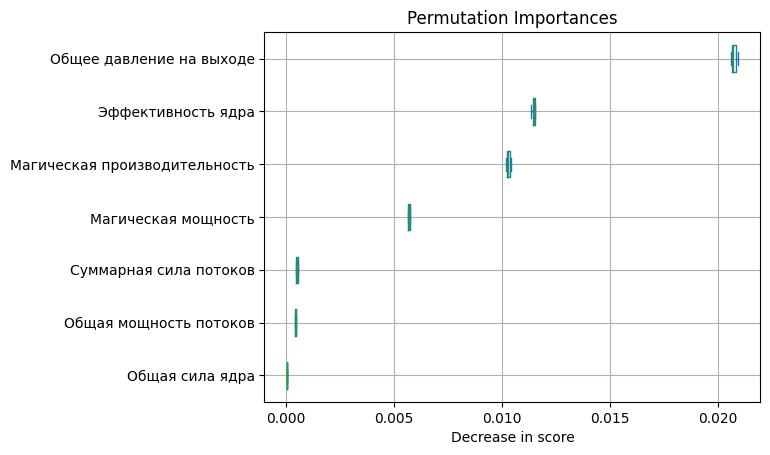

In [ ]:
best_knn2 = KNeighborsRegressor(**study.best_params).fit(X_train, y_train2)

result = permutation_importance(best_knn2, X_train, y_train2, n_repeats=10, random_state=0, n_jobs=-1, scoring='neg_mean_absolute_error')
sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

importances.plot.box(vert=False, whis=10)
plt.title("Permutation Importances")
plt.grid()
plt.xlabel("Decrease in score")
plt.show()

Вновь показана слабая эффективность признаков *Общая сила ядра* и *Суммарная сила потоков*; для данного таргета к ним еще можно вполне добавить *Общую мощность потоков*

Рассчитаем метрики качества

In [ ]:
knn2_mae = mean_absolute_error(data_old.loc[y_test2.index, 'Гармония Бессмертия'], data.loc[y_test2.index, 'Дыхание Истока'] / best_knn2.predict(X_test))
model_maes.append(knn2_mae)
knn2_mae

0.002426312872135346

In [ ]:
knn2_relmae = knn2_mae / baseline_mae2
model_relmaes.append(knn2_relmae)
knn2_relmae

0.1745187941878599

In [ ]:
knn2_relmae_best = knn2_mae / best_baseline_mae
model_relmaes_best.append(knn2_relmae_best)
knn2_relmae_best

0.1749869372468263

Показатели несколько хуже, чем в предыдущем случае, но сопоставимы; улучшение относительно базовых прогнозов - так же примерно в 6 раз

### Target - Расхождение в стабильности

In [ ]:
def objective_knn3(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 200, log=False),
        'weights': 'distance',
        'p': trial.suggest_float('p', 1, 5, log=False)
    }

    regr = KNeighborsRegressor(**params)

    return cross_val_score(regr, X_train, y_train3, scoring='neg_mean_absolute_error').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn3, n_trials=100)

[I 2024-11-13 12:34:37,626] A new study created in memory with name: no-name-0117480c-6f62-458a-8312-f2855e986ad8
[I 2024-11-13 12:34:37,947] Trial 0 finished with value: -0.002517605120803882 and parameters: {'n_neighbors': 12, 'p': 2.9045527580735344}. Best is trial 0 with value: -0.002517605120803882.
[I 2024-11-13 12:34:38,953] Trial 1 finished with value: -0.00517818349192275 and parameters: {'n_neighbors': 141, 'p': 2.8285699234113233}. Best is trial 0 with value: -0.002517605120803882.
[I 2024-11-13 12:34:39,780] Trial 2 finished with value: -0.004660581251343494 and parameters: {'n_neighbors': 102, 'p': 1.3866382485428357}. Best is trial 0 with value: -0.002517605120803882.
[I 2024-11-13 12:34:40,906] Trial 3 finished with value: -0.004933344921276991 and parameters: {'n_neighbors': 122, 'p': 1.634518927878462}. Best is trial 0 with value: -0.002517605120803882.
[I 2024-11-13 12:34:42,045] Trial 4 finished with value: -0.004665989657144538 and parameters: {'n_neighbors': 102, '

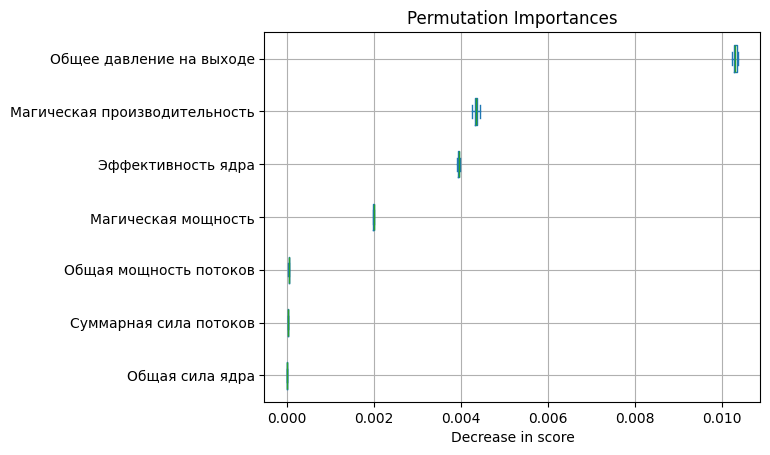

In [ ]:
best_knn3 = KNeighborsRegressor(**study.best_params).fit(X_train, y_train3)

result = permutation_importance(best_knn3, X_train, y_train3, n_repeats=10, random_state=0, n_jobs=-1, scoring='neg_mean_absolute_error')
sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

importances.plot.box(vert=False, whis=10)
plt.title("Permutation Importances")
plt.grid()
plt.xlabel("Decrease in score")
plt.show()

Те же самые три переменных вновь продемонстрировали низкую эффективность (теперь еще более явно)

Расчитаем метрики качества

In [ ]:
knn3_mae = mean_absolute_error(data_old.loc[y_test3.index, 'Гармония Бессмертия'], data.loc[y_test3.index, 'Дыхание Истока'] + best_knn3.predict(X_test))
model_maes.append(knn3_mae)

knn3_mae

0.006099320487759477

In [ ]:
knn3_relmae = knn3_mae / baseline_mae3
model_relmaes.append(knn3_relmae)

knn3_relmae

0.43988614316691166

In [ ]:
knn3_relmae_best = knn3_mae / best_baseline_mae
model_relmaes_best.append(knn3_relmae_best)
knn3_relmae_best

0.43988614316691166

Тем не менее, данная модель оказался сильно хуже предыдущих: так, она лучше константной всего лишь в два раза

### Усреднение прогнозов по трем таргетам

Можно попробовать усреднять преобразованные прогнозы трех моделей, тем самым несколько компенсируя отклонения

In [ ]:
pred1 = data.loc[y_test1.index, 'Дыхание Истока'] - data.loc[y_test1.index, 'Скорость перехода через портал'] * best_knn1.predict(X_test)
pred2 = data.loc[y_test2.index, 'Дыхание Истока'] / best_knn2.predict(X_test)
pred3 = data.loc[y_test3.index, 'Дыхание Истока'] + best_knn3.predict(X_test)

mean_predict = (pred1 + pred2 + pred3) / 3

knn_mean_mae = mean_absolute_error(data_old.loc[y_test2.index, 'Гармония Бессмертия'], mean_predict)
model_maes.append(knn_mean_mae)
knn_mean_mae

0.0034589499035280508

In [ ]:
knn_mean_relmae = knn_mean_mae / const_mean_mae
model_relmaes.append(knn_mean_relmae)
knn_mean_relmae

0.24752520931859548

In [ ]:
knn_mean_relmae_best = knn_mean_mae / best_baseline_mae
model_relmaes_best.append(knn_mean_relmae_best)
knn_mean_relmae_best

0.24946125318780207

Хотя качество усреднения оказалось лучше бейзлайна примерно в 5 раз, все же оно хуже первого и второго вариантов

## Boosting

Другим логичным вариантом для улучшения является применение градиентного бустинга - пожалуй лучшего алгоритма для работы с табличными данными. У бустинга над деревьями имеется большое количество гиперпараметров, так что подбираются на кросс-валидации лишь некоторые из них, а именно: *темп обучения*, *кол-во листьев в деревьях*, *максимальная глубина деревьев*, *общее число деревьев* и *коэффициенты регуляризации*. Для оценки важности признаков используется встроенный показатель ```importance gain```.  

### Target - Баланс угасания

In [ ]:
def objective_boosting1(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 2, 20),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1, log=False),
        'random_state': 42
    }

    regr = LGBMRegressor(**params, verbosity=-1)

    return cross_val_score(regr, X_train, y_train1, scoring='neg_mean_absolute_error').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_boosting1, n_trials=100)

[I 2024-11-13 12:35:57,733] A new study created in memory with name: no-name-6d89f8ca-7bd2-4d26-bd98-f32bfdeb91ab
[I 2024-11-13 12:35:58,303] Trial 0 finished with value: -0.0014823922229557003 and parameters: {'learning_rate': 0.4166038527942517, 'num_leaves': 19, 'n_estimators': 218, 'max_depth': 10, 'reg_alpha': 0.3601847775815732, 'reg_lambda': 0.9035013177792174}. Best is trial 0 with value: -0.0014823922229557003.
[I 2024-11-13 12:35:58,818] Trial 1 finished with value: -0.0015787090527494157 and parameters: {'learning_rate': 0.922215541286346, 'num_leaves': 4, 'n_estimators': 345, 'max_depth': 7, 'reg_alpha': 0.3338178338282458, 'reg_lambda': 0.404288673633565}. Best is trial 0 with value: -0.0014823922229557003.
[I 2024-11-13 12:35:59,239] Trial 2 finished with value: -0.0018444638541330952 and parameters: {'learning_rate': 0.262886662350607, 'num_leaves': 4, 'n_estimators': 437, 'max_depth': 3, 'reg_alpha': 0.4512238357555768, 'reg_lambda': 0.708538783957448}. Best is trial 0 

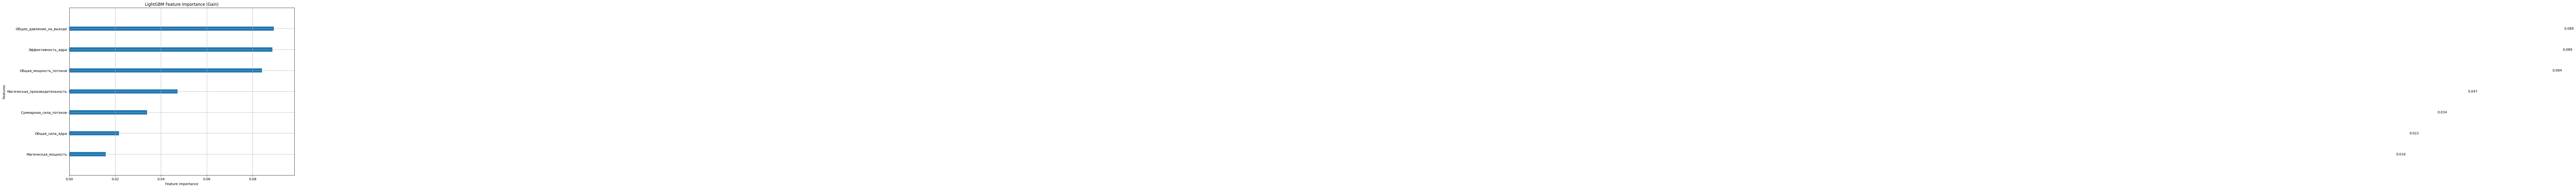

In [ ]:
best_boosting1 = LGBMRegressor(**study.best_params, verbosity=-1).fit(X_train, y_train1)

# Тут и далее у графиков могут поехать числа над столбцам - странный визуальный баг, пофиксить не получилось
plot_importance(best_boosting1, importance_type="gain", figsize=(12,9), title="LightGBM Feature Importance (Gain)")
plt.show()

По графику видно, что бустинг смог выжать из каждого признака некоторую информацию; при этом признак *Общая мощность потоков* показал себя значительно лучше, чем в моделях ближайших соседей.

Расчитаем метрики качества

In [ ]:
boost1_mae = mean_absolute_error(data_old.loc[y_test1.index, 'Гармония Бессмертия'],  data.loc[y_test1.index, 'Дыхание Истока'] -
                               data.loc[y_test1.index, 'Скорость перехода через портал'] * best_boosting1.predict(X_test))
model_maes.append(boost1_mae)
boost1_mae

0.001738057420806617

In [ ]:
boost1_relmae = boost1_mae / baseline_mae1
model_relmaes.append(boost1_relmae)
boost1_relmae

0.11787066432922993

In [ ]:
boost1_relmae_best = boost1_mae / best_baseline_mae
model_relmaes_best.append(boost1_relmae_best)
boost1_relmae_best

0.1253495986930999

По полученным значениям видно, что градиентный бустинг превзошел все модели, рассмотренные ранее, и позволил улучшит качество предсказания относительно базы примерно в 8 раз

### Target - Степень износа источников

In [ ]:
def objective_boosting2(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 2, 20),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1, log=False),
        'random_state': 42
    }

    regr = LGBMRegressor(**params, verbosity=-1)

    return cross_val_score(regr, X_train, y_train2, scoring='neg_mean_absolute_error').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_boosting2, n_trials=100)

[I 2024-11-13 12:37:10,205] A new study created in memory with name: no-name-80a072c2-85df-426b-91ce-05fce498b175
[I 2024-11-13 12:37:11,448] Trial 0 finished with value: -0.0020963507622542166 and parameters: {'learning_rate': 0.4520973614381004, 'num_leaves': 20, 'n_estimators': 211, 'max_depth': 8, 'reg_alpha': 0.05588940239980211, 'reg_lambda': 0.4612261675635474}. Best is trial 0 with value: -0.0020963507622542166.
[I 2024-11-13 12:37:12,107] Trial 1 finished with value: -0.004829072264798405 and parameters: {'learning_rate': 0.38355800443712984, 'num_leaves': 14, 'n_estimators': 369, 'max_depth': 7, 'reg_alpha': 0.965649954277698, 'reg_lambda': 0.9365423206342017}. Best is trial 0 with value: -0.0020963507622542166.
[I 2024-11-13 12:37:12,626] Trial 2 finished with value: -0.005057405195396621 and parameters: {'learning_rate': 0.5652345602000787, 'num_leaves': 18, 'n_estimators': 327, 'max_depth': 4, 'reg_alpha': 0.9993507883268897, 'reg_lambda': 0.2808272010005157}. Best is tria

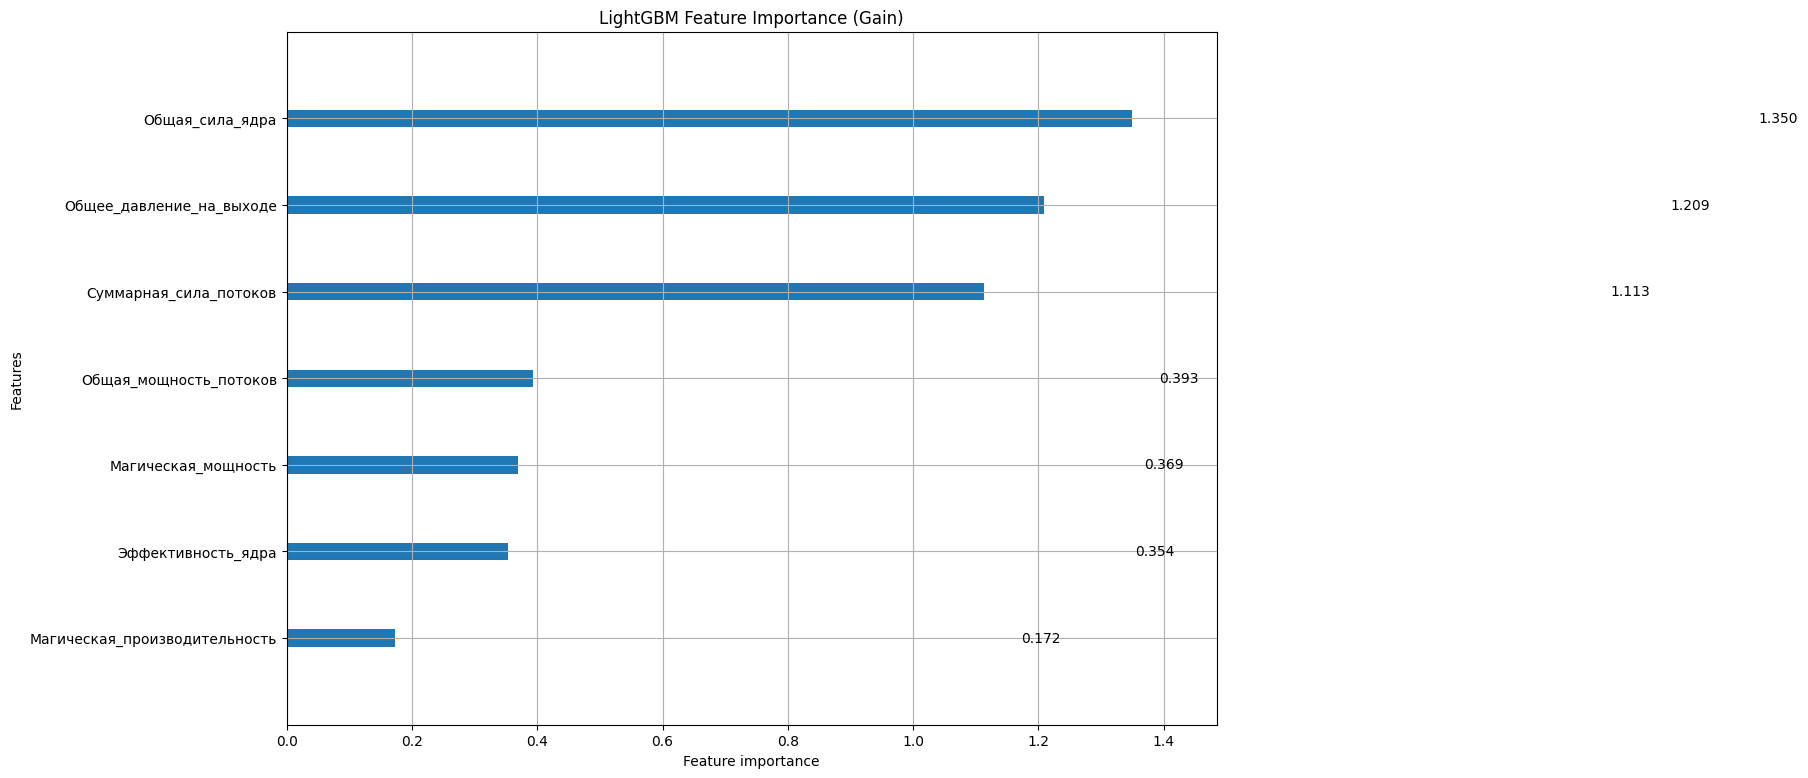

In [ ]:
best_boosting2 = LGBMRegressor(**study.best_params, verbosity=-1).fit(X_train, y_train2)

plot_importance(best_boosting2, importance_type="gain", figsize=(12,9), title="LightGBM Feature Importance (Gain)", precision=3)
plt.show()

И снова по графику нельзя сказать, что какой-либо признак оказался "мусорным"; однако явно прослеживается существенный разрыв между приростами от первых трех признаков и приростами от остальных. Примечательно, что слабый с точки зрения KNN-моделей признак *Общая сила ядра* в данном случае продемонстрировал наибольшую эффективность

Рассчитаем метрики качества

In [ ]:
boost2_mae = mean_absolute_error(data_old.loc[y_test1.index, 'Гармония Бессмертия'], data.loc[y_test2.index, 'Дыхание Истока'] / best_boosting2.predict(X_test))
model_maes.append(boost2_mae)
boost2_mae

0.0014913701622704034

In [ ]:
boost2_relmae = boost2_mae / baseline_mae2
model_relmaes.append(boost2_relmae)
boost2_relmae

0.10727063496066104

In [ ]:
boost2_relmae_best = boost2_mae / best_baseline_mae
model_relmaes_best.append(boost2_relmae_best)
boost2_relmae_best

0.10755838622218816

Снова бустинг улучшил качество предсказания, доведя улучшение метрики уже почти до 10 раз относительно бейзлайна

### Target - Расхождение в стабильности

In [ ]:
def objective_boosting3(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 2, 20),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1, log=False),
        'random_state': 42
    }

    regr = LGBMRegressor(**params, verbosity=-1)

    return cross_val_score(regr, X_train, y_train3, scoring='neg_mean_absolute_error').mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_boosting3, n_trials=100)

[I 2024-11-13 12:38:48,299] A new study created in memory with name: no-name-8d2518a2-a427-4239-a735-40744e64fe4f
[I 2024-11-13 12:38:48,703] Trial 0 finished with value: -0.004319937495770997 and parameters: {'learning_rate': 0.6969304922897372, 'num_leaves': 19, 'n_estimators': 393, 'max_depth': 4, 'reg_alpha': 0.6443091444996037, 'reg_lambda': 0.0656944702236939}. Best is trial 0 with value: -0.004319937495770997.
[I 2024-11-13 12:38:49,160] Trial 1 finished with value: -0.004083438939032935 and parameters: {'learning_rate': 0.16168870888431422, 'num_leaves': 4, 'n_estimators': 191, 'max_depth': 12, 'reg_alpha': 0.3818942317164784, 'reg_lambda': 0.8197034153510645}. Best is trial 1 with value: -0.004083438939032935.
[I 2024-11-13 12:38:49,443] Trial 2 finished with value: -0.003586153667799101 and parameters: {'learning_rate': 0.4906704926608185, 'num_leaves': 17, 'n_estimators': 105, 'max_depth': 2, 'reg_alpha': 0.11363027994093222, 'reg_lambda': 0.17295419378468557}. Best is trial

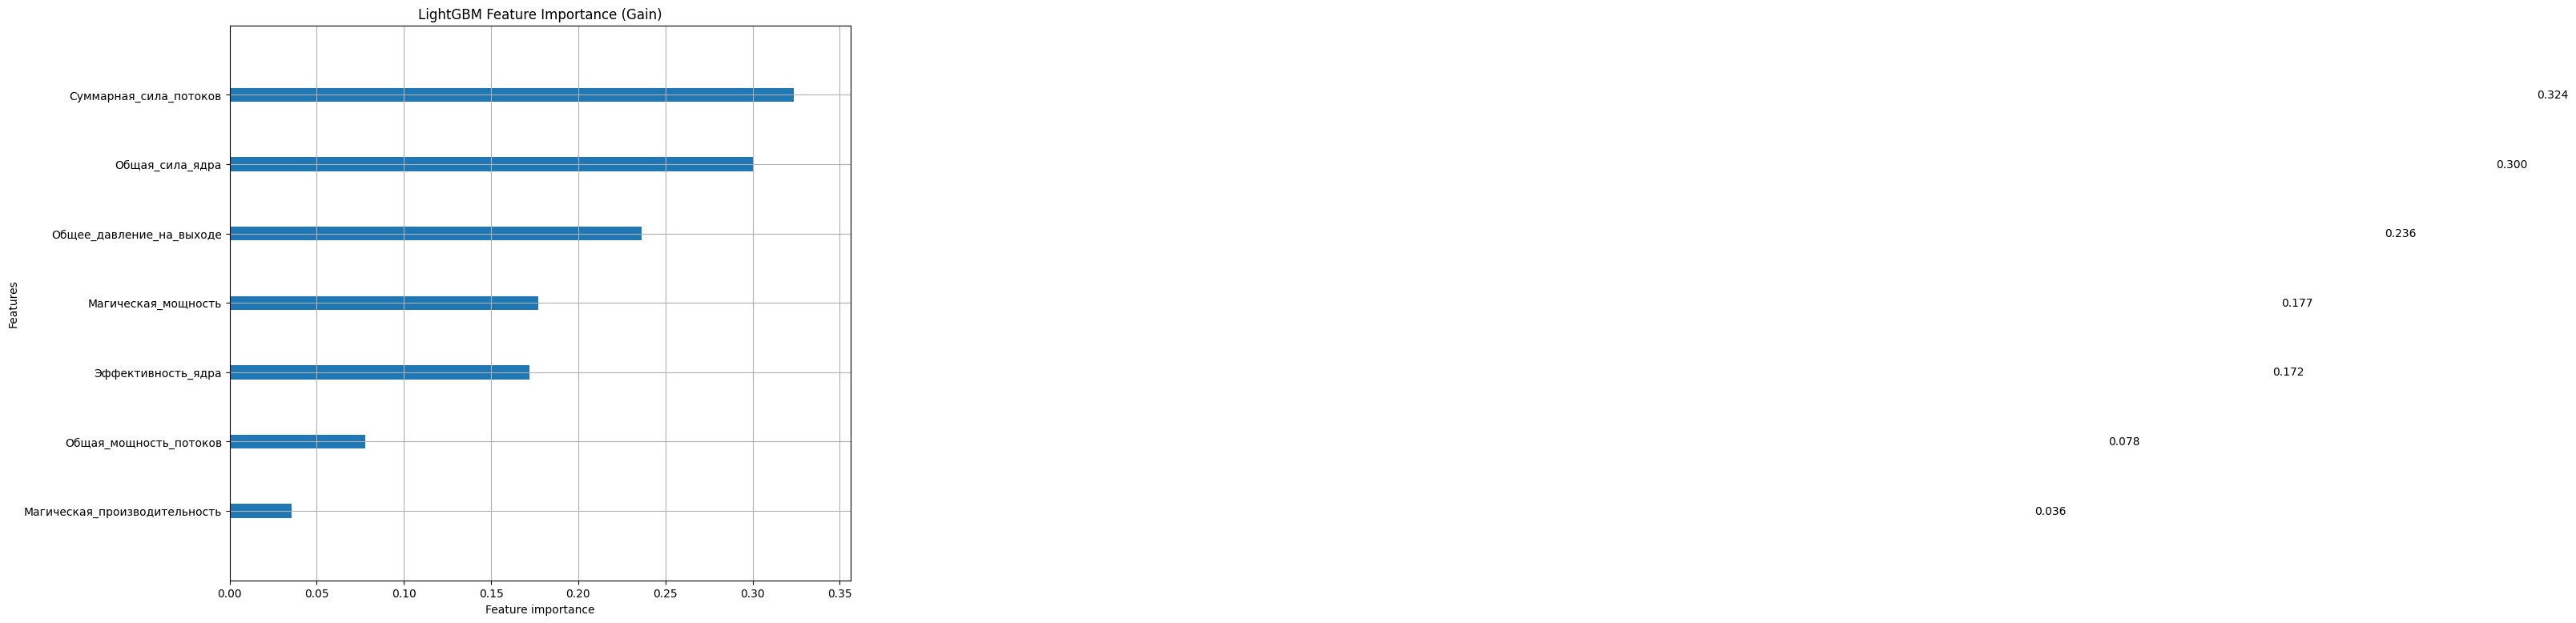

In [ ]:
best_boosting3 = LGBMRegressor(**study.best_params, verbosity=-1).fit(X_train, y_train3)

plot_importance(best_boosting3, importance_type="gain", figsize=(10,9), title="LightGBM Feature Importance (Gain)")
plt.show()

Снова все признаки так или иначе внесли вклад в построение деревьев, ну и разрыв в приростах перестал быть настолько сильным (как это имело место в предыдущем случае)

Рассчитаем метрики качества

In [ ]:
boost3_mae = mean_absolute_error(data_old.loc[y_test3.index, 'Гармония Бессмертия'], data.loc[y_test3.index, 'Дыхание Истока'] + best_boosting3.predict(X_test))
model_maes.append(boost3_mae)

boost3_mae

0.005417356042809183

In [ ]:
boost3_relmae = boost3_mae / baseline_mae3
model_relmaes.append(boost3_relmae)

boost3_relmae

0.3907025152417712

In [ ]:
boost3_relmae_best = boost3_mae / best_baseline_mae
model_relmaes_best.append(boost3_relmae_best)
boost3_relmae_best

0.3907025152417712

Последний бустинг оказался достаточно слабым, проигрывающим даже методам ближайших соседей. Вспоминая о том, что то же самое было и в KNN, можно предположить, что низкое качество вызвано неподходящей под задачу целевой переменной (слишком мало уникальных значений)  

### Усреднение по трем таргетам

Напоследок, можно попробовать усреднить преобразованные прогнозы трех бустингов и оценить качество

In [ ]:
pred1 = data.loc[y_test1.index, 'Дыхание Истока'] - data.loc[y_test1.index, 'Скорость перехода через портал'] * best_boosting1.predict(X_test)
pred2 = data.loc[y_test2.index, 'Дыхание Истока'] / best_boosting2.predict(X_test)
pred3 = data.loc[y_test3.index, 'Дыхание Истока'] + best_boosting3.predict(X_test)

mean_predict = (pred1 + pred2 + pred3) / 3

boost_mean_mae = mean_absolute_error(data_old.loc[y_test2.index, 'Гармония Бессмертия'], mean_predict)
model_maes.append(boost_mean_mae)
boost_mean_mae

0.0025194294137606994

In [ ]:
boost_mean_relmae = mean_absolute_error(data_old.loc[y_test2.index, 'Гармония Бессмертия'], mean_predict) / const_mean_mae
model_relmaes.append(boost_mean_relmae)
boost_mean_relmae

0.18029237496861772

In [ ]:
boost_mean_relmae_best = boost_mean_mae / best_baseline_mae
model_relmaes_best.append(boost_mean_relmae_best)
boost_mean_relmae_best

0.18170255031271132

Ничего лучше одиночной модели на *Степени износа* добиться не удалось

# Итоги

Сведем все результаты в единую таблицу

In [ ]:
iterables = [["KNN", "Gradient Boosting"], ["Баланс Угасания", "Степень износа", "Расхождение в стабильности", "Среднее по трем"]]
index = pd.MultiIndex.from_product(iterables, names=["Model", "Target"])

results = pd.DataFrame({"MAE": model_maes, "relMAE": model_relmaes, "relMAE best": model_relmaes_best}, index=index)
results

MAE    relMAE  relMAE best
Model             Target                                                     
KNN               Баланс Угасания             0.002366  0.160450     0.170631
                  Степень износа              0.002426  0.174519     0.174987
                  Расхождение в стабильности  0.006099  0.439886     0.439886
                  Среднее по трем             0.003459  0.247525     0.249461
Gradient Boosting Баланс Угасания             0.001738  0.117871     0.125350
                  Степень износа              0.001491  0.107271     0.107558
                  Расхождение в стабильности  0.005417  0.390703     0.390703
                  Среднее по трем             0.002519  0.180292     0.181703

Подведем некоторые итоги по проделанной работе:

1.  В изначальных данных присутствовало большое количество проблем, как по части целевой переменной, так и по части признаков. В связи с этим, удобно было воспльзоваться советом из задания и перейти к новому признаковому пространству и производным целевым переменным.

2.  Для оценки качества моделей были выбраны два показателя: средняя абсолютная ошибка (MAE) и относительная средняя абсолютная ошибка (relMAE): первая позволяет охарктеризовать непосредственно точность предсказаний модели, вторая - относительный эффект применения модели относительно предсказания наилучшей константой.

3. В качестве классов рассматриваемых моделей были выбраны модель ближайших соседей (KNNRegressor) и модель градиентного бустинга (LGBMRegressor). Выбранные классы обладают наибольшей устойчивость к мультиколлинеарности признаков, а также лучше проявлять в задачах регрессии с полу-дискретной целевой переменной (уникальных значений таргета существенно меньше числа наблюдений)

4. Модели строились для всех заготовленных производных целевых переменных; сначала на кросс-валидации подбирались гиперпараметры, после оптимальная модель обучалась и ее качество оценивалось на отложенной выборке.

5. Наилучшей моделью с точки зрения выбранной метрики оказался **градиентный бустинг над целевой переменной *Степень износа источников***: среднее абсолютное отклонение составило порядка 0.0015, а само внедрение этой модели позволило повысить качество практически в 10 раз, по отношению к простому прогнозу оптимальной константой


В завершении хотелось бы отметить, что полученный результат не является предельным и при желании его можно попытаться сделать еще лучше: так можно попробовать построить другие, более комплексные ансамбли или придумать новые, более информативные признаки. Тем не менее, достигнутое качество уже представляется достаточно хорошим, а дальнейшее усложнение архитектуры модели/использование сложных синтетических признаков может привести к серьезному переобучению получаемых моделей